## Projeto final de Ciência dos Dados: Classificação de Pokémons a partir da sua cor e... 
----------------------
##### Feito por:
Enrico Aloisi Nardi e Evandro Fontana Romeiro- 2º semestre de engenharia (Insper 2018)


##### Ideia geral do projeto:
A partir do que será apresentado, buscaremos tentar encontrar uma relação explícita entre os stats de um Pokémon, a sua cor e a sua categoria para então prever se existe um agrupamento natural deles mesmo que pertençam a diferentes gerações.

In [152]:
# Imports necessários para o projeto:
import os
import colorsys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from colorthief import ColorThief
from mpl_toolkits.mplot3d import Axes3D
from pandas import DataFrame as df
from sklearn import cluster
from pandas import ExcelWriter
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import seaborn as sns

In [3]:
data= pd.read_csv('Pokemon.csv') #lendo o database baixado do kaggle 

#O bloco a seguir encontra-se comentado para que o comando criador.save() não interfira nas alterações feitas no excel pelo computador
#transformando o database csv em excel para poder eliminar incongruências entre a base de fotos e a de dados sobre os 
#Pokémons
# criador = ExcelWriter('Pokexcel.xlsx')                         
# data.to_excel(criador,'Sheet5')
# criador.save()  

Daqui em diante, uma vez que o algoritmo do KMeans não trabalha com strings, foi feita a seguinte mudança do nome da categoria de um Pokémon para um número (a necessidade de repetir números é explicada detalhadamente no relatório no final deste arquivo):

| Categoria primária    | Número equivalente   | Número de pokémons na categoria          
| ------------- |:-------------  |:------------
     | Water    | 0             | 112
     | Normal   | 0             |  98
     | Grass    | 1             |  70
     | Bug      | 1             |  69
     | Psychic  | 2             |  57
     | Fire     | 2             |  52
     | Electric | 2             |  44
     | Rock     | 3             |  44
     | Ghost    | 4             |  32
     | Dragon   | 5             |  32
     | Ground   | 6             |  32
     | Dark     | 6             |  31
     | Poison   | 7             |  28
     | Steel    | 7             |  27
     | Fighting | 8             |  27
     | Ice      | 8             |  24
     | Fairy    | 9             |  17
     | Flying   | 10             |   4

Histograma que permite a visualização geral da distribuição dos pokémons de acordo com o seu tipo principal (Type 1)


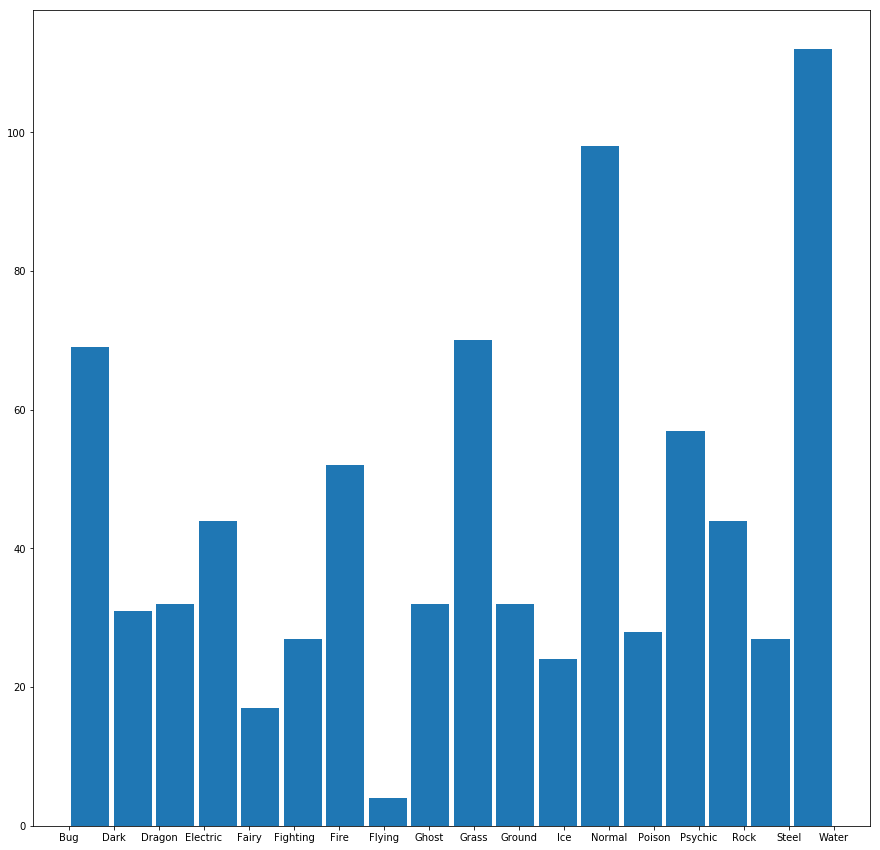

In [14]:
plt.hist(data['Type 1'], rwidth= .9, bins= 18);
plt.rcParams['figure.figsize'] = (15,15)

## Clusterizando com o KMeans

Lendo os dados com o tamanho já acertado para ser compatível com a base de imagens

In [5]:
data_final = pd.read_excel('Pokexcel.xlsx') #lendo os dados já alterados e com o mesmo número de fotos
data_final.head(3)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


Extraindo a cor predominante de cada imagem e armazenando-a em listas nos formatos RGB e HSV. Todas as linhas da célula abaixo encontram-se comentados pois ela demora muito para processar as 804 fotos da pasta e os valores necessários já foram guardados nas suas respectivas variáveis.

In [6]:
# lis_cores_rgb_f = [] #lista que guardará os códigos RGB das cores predominantes em cada foto

# lis_cores_hsv_f = [] #lista que guardará os códigos HSV das cores predominantes em cada foto

# path = 'C:/Users/Enrico Aloisi Nardi/Desktop/Insper/SEGUNDO semestre/Ciência dos Dados/Projeto 3/Projeto-3--CDD/pokeimagens/'
# arq_na_pasta= os.listdir(path)

# for foto in arq_na_pasta:
#     color_thief = ColorThief(path + foto)

#     #recebendo a cor predominante de cada foto
#     cor_predominante_f = color_thief.get_color(quality=1)
#     lis_cores_rgb_f.append(cor_predominante_f)
    
#     # Colocando a variável "cor predominante" numa função que converte um código de cores RGB em HSV e vice-versa.
#     # Ela será utilzada para aumentar a 'precisão' da leitura da cor da foto feita pelo ColouThief, que entrega o resultado em RGB.
#     # Com a conversão RGB-HSV buscamos reduzir confusões feitas pelo programa por conta de pequenas diferenças na cor lida.
#     cor_predominante_hsv_f = colorsys.rgb_to_hsv(cor_predominante_f[0], cor_predominante_f[1], cor_predominante_f[2])
    
#     lis_cores_hsv_f.append(cor_predominante_hsv_f[0] * 360)

Mudando a categoria do Pokémon de texto para número, uma vez que este é o único input aceito pelo algoritmo do KMeans.

In [161]:
data_final['H'] = [x for x in lis_cores_hsv_f]

data_final.loc[data_final['Type 1'] == 'Water'   , "Categoria_Num"] = "0"
data_final.loc[data_final['Type 1'] == 'Ice'     , "Categoria_Num"] = "0"
data_final.loc[data_final['Type 1'] == 'Fighting', "Categoria_Num"] = "1"
data_final.loc[data_final['Type 1'] == 'Normal'  , "Categoria_Num"] = "1"
data_final.loc[data_final['Type 1'] == 'Poison'  , "Categoria_Num"] = "2"
data_final.loc[data_final['Type 1'] == 'Grass'   , "Categoria_Num"] = "2"
data_final.loc[data_final['Type 1'] == 'Bug'     , "Categoria_Num"] = "2"
data_final.loc[data_final['Type 1'] == 'Psychic' , "Categoria_Num"] = "3"
data_final.loc[data_final['Type 1'] == 'Fire'    , "Categoria_Num"] = "4"
data_final.loc[data_final['Type 1'] == 'Electric', "Categoria_Num"] = "5"
data_final.loc[data_final['Type 1'] == 'Ground'  , "Categoria_Num"] = "6"
data_final.loc[data_final['Type 1'] == 'Rock'    , "Categoria_Num"] = "6"
data_final.loc[data_final['Type 1'] == 'Ghost'   , "Categoria_Num"] = "7"
data_final.loc[data_final['Type 1'] == 'Dark'    , "Categoria_Num"] = "7"
data_final.loc[data_final['Type 1'] == 'Dragon'  , "Categoria_Num"] = "8"
data_final.loc[data_final['Type 1'] == 'Flying'  , "Categoria_Num"] = "8"
data_final.loc[data_final['Type 1'] == 'Steel'   , "Categoria_Num"] = "9"
data_final.loc[data_final['Type 1'] == 'Fairy'   , "Categoria_Num"] = "10"

data_f = data_final.drop(['Type 1','Type 2','Legendary','Name','#'], axis= 1)
data_f.head(3)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,H,Categoria_Num
0,318,45,49,49,65,65,45,1,152.000000,2
1,405,60,62,63,80,80,60,1,97.941176,2
2,525,80,82,83,100,100,80,1,349.230769,2


Histograma com o número de pokémons por cluster encontrado pelo algoritmo do KMeans

In [162]:
KM= KMeans(n_clusters= 10, init= 'k-means++', n_init= 20) #o número de clusters foi definido a partir do número de dados categorias diferentes de Pokémons
KM.fit(data_f)
y_pred = KM.predict(data_f) #lista que guarda qual é o cluster ao qual pertence cada um dos pokémons
# plt.hist(y_pred, rwidth=.9, bins= 18);

data_f["Cluster_KM"]= y_pred #adicionando ao dataframe o cluster atribuído a cada pokémon via KMeans
data_f.head(3)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,H,Categoria_Num,Cluster_KM
0,318,45,49,49,65,65,45,1,152.000000,2,4
1,405,60,62,63,80,80,60,1,97.941176,2,1
2,525,80,82,83,100,100,80,1,349.230769,2,3


In [163]:
# data_f.corr(method='pearson')

In [164]:
# pd.scatter_matrix(data_f, alpha = 1, figsize=(20,20));
# plt.figure(figsize=(12,12))

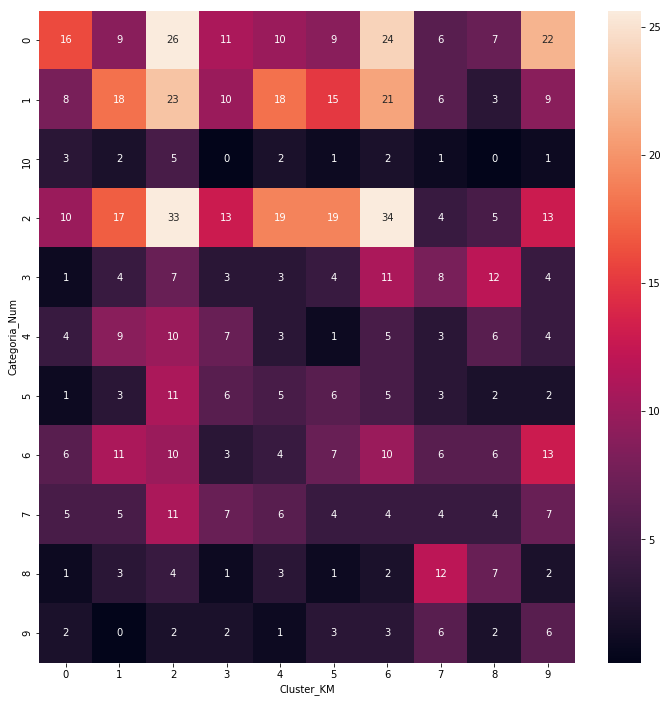

In [165]:
plt.figure(figsize=(12,12))
sns.heatmap(pd.crosstab(data_f["Categoria_Num"],data_f["Cluster_KM"]), annot=True, robust= True);

In [222]:
#separando os pokémons a partir do cluster no qual eles foram colocados pelo algoritmo do KMeans
c0_KM  = data_f.loc[data_f["Cluster_KM"]  ==  0 ]
c1_KM  = data_f.loc[data_f["Cluster_KM"]  ==  1 ]
c2_KM  = data_f.loc[data_f["Cluster_KM"]  ==  2 ]
c3_KM  = data_f.loc[data_f["Cluster_KM"]  ==  3 ]
c4_KM  = data_f.loc[data_f["Cluster_KM"]  ==  4 ]
c5_KM  = data_f.loc[data_f["Cluster_KM"]  ==  5 ]
c6_KM  = data_f.loc[data_f["Cluster_KM"]  ==  6 ]
c7_KM  = data_f.loc[data_f["Cluster_KM"]  ==  7 ]
c8_KM  = data_f.loc[data_f["Cluster_KM"]  ==  8 ]
c9_KM  = data_f.loc[data_f["Cluster_KM"]  ==  9 ]

In [175]:
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D

# plt3d = plt.figure().gca(projection="3d")
# plt3d.scatter(c0_KM.Total, c0_KM.H, c0_KM.Generation, color="r")
# plt3d.scatter(c1_KM.Total, c1_KM.H, c1_KM.Generation, color="g")
# plt3d.scatter(c2_KM.Total, c2_KM.H, c2_KM.Generation, color="b")
# plt3d.scatter(c3_KM.Total, c3_KM.H, c3_KM.Generation, color="c")
# plt3d.scatter(c4_KM.Total, c4_KM.H, c4_KM.Generation, color="y")
# plt3d.scatter(c5_KM.Total, c5_KM.H, c5_KM.Generation, color="k")
# plt3d.scatter(c6_KM.Total, c6_KM.H, c6_KM.Generation, color="m")
# plt3d.scatter(c7_KM.Total, c7_KM.H, c7_KM.Generation, color="orange")
# plt3d.scatter(c8_KM.Total, c8_KM.H, c8_KM.Generation, color="navy")
# plt3d.scatter(c9_KM.Total, c9_KM.H, c9_KM.Generation, color="sienna")

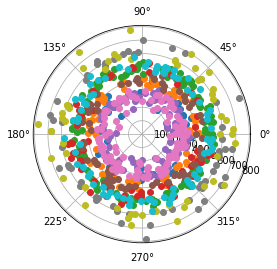

In [215]:
%matplotlib inline
ax = plt.subplot(111, projection='polar')
ax.plot(c0_KM.H, c0_KM.Total, 'o')
ax.plot(c1_KM.H, c1_KM.Total, 'o')
ax.plot(c2_KM.H, c2_KM.Total, 'o')
ax.plot(c3_KM.H, c3_KM.Total, 'o')
ax.plot(c4_KM.H, c4_KM.Total, 'o')
ax.plot(c5_KM.H, c5_KM.Total, 'o')
ax.plot(c6_KM.H, c6_KM.Total, 'o')
ax.plot(c7_KM.H, c7_KM.Total, 'o')
ax.plot(c8_KM.H, c8_KM.Total, 'o')
ax.plot(c9_KM.H, c9_KM.Total, 'o')
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

## Clusterizando com a Gaussian Mixture

In [217]:
GMM = GaussianMixture(n_components= 10)

GMM.fit(data_f)
thirdtry = GMM.predict(data_f) #lista que guarda qual é o cluster ao qual pertence cada um dos pokémons
# plt.hist(y_pred, rwidth=.9, bins= 18);

data_f["Cluster_GMM"]= thirdtry #adicionando ao dataframe o cluster atribuído a cada pokémon via KMeans
data_f.head(3)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,H,Categoria_Num,Cluster_KM,Cluster_GMM
0,318,45,49,49,65,65,45,1,152.000000,2,4,0
1,405,60,62,63,80,80,60,1,97.941176,2,1,4
2,525,80,82,83,100,100,80,1,349.230769,2,3,3


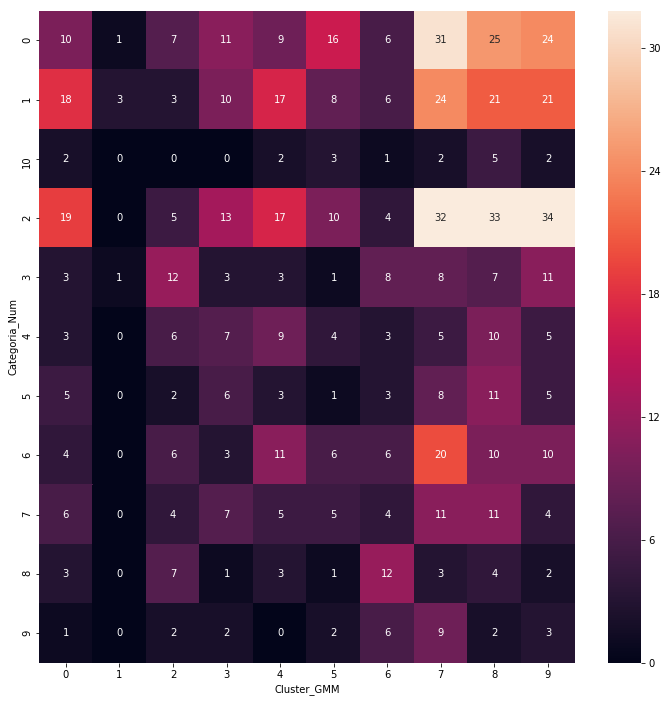

In [218]:
# pd.scatter_matrix(data_f, alpha = 1, figsize=(20,20));
plt.figure(figsize=(12,12))
sns.heatmap(pd.crosstab(data_f["Categoria_Num"],data_f["Cluster_GMM"]), annot=True, robust= True);

Separando os pokémons a partir do cluster no qual eles foram colocados pelo algoritmo do Gaussian Mixture.

In [225]:
c0_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  0 ]
c1_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  1 ]
c2_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  2 ]
c3_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  3 ]
c4_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  4 ]
c5_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  5 ]
c6_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  6 ]
c7_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  7 ]
c8_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  8 ]
c9_GMM  = data_f.loc[data_f["Cluster_GMM"]  ==  9 ]

<IPython.core.display.Javascript object>


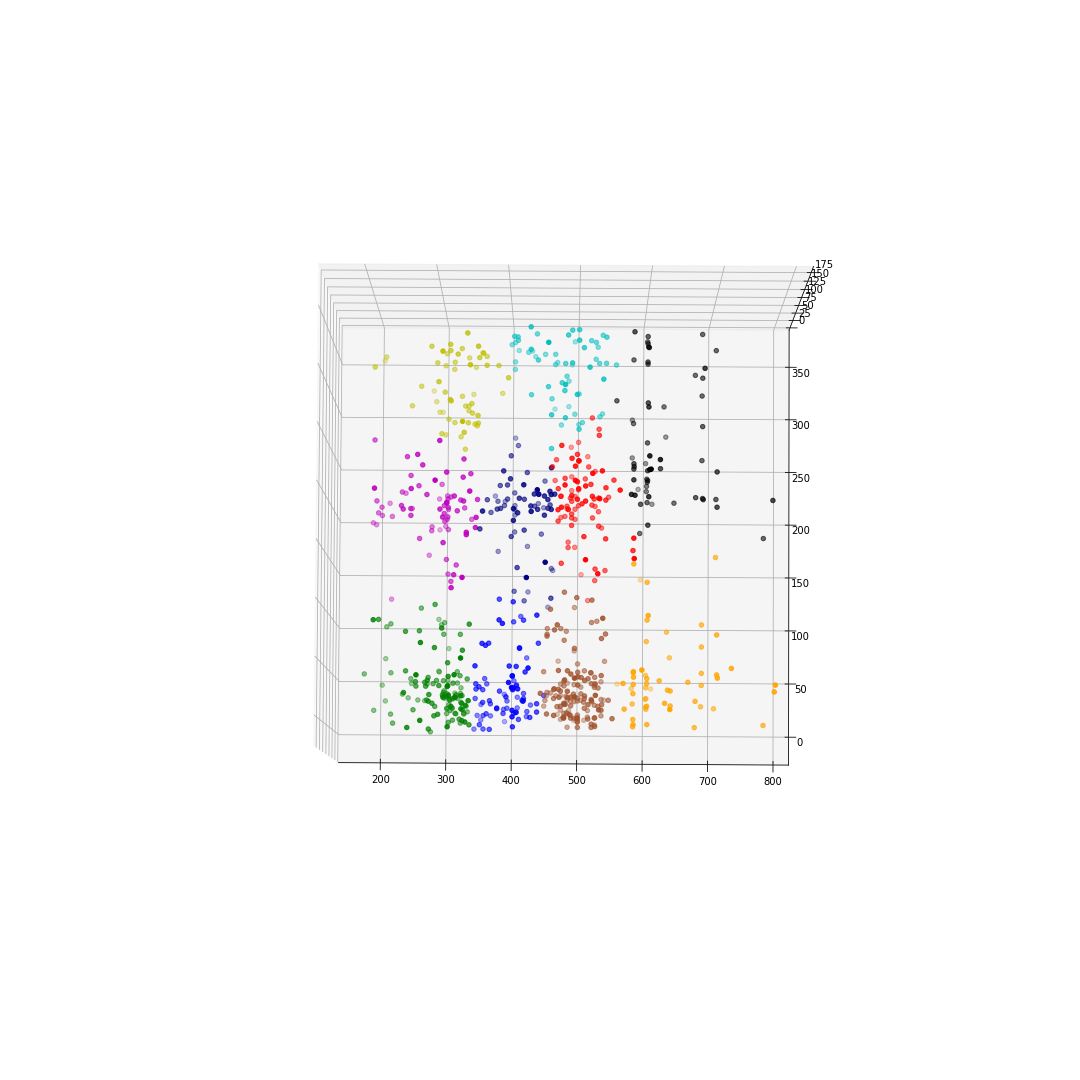

In [146]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

plt3d = plt.figure().gca(projection="3d")
plt3d.scatter(c0_GMM.Total, c0_GMM.H, c0_GMM.Speed, color="r")
plt3d.scatter(c1_GMM.Total, c1_GMM.H, c1_GMM.Speed, color="g")
plt3d.scatter(c2_GMM.Total, c2_GMM.H, c2_GMM.Speed, color="b")
plt3d.scatter(c3_GMM.Total, c3_GMM.H, c3_GMM.Speed, color="c")
plt3d.scatter(c4_GMM.Total, c4_GMM.H, c4_GMM.Speed, color="y")
plt3d.scatter(c5_GMM.Total, c5_GMM.H, c5_GMM.Speed, color="k")
plt3d.scatter(c6_GMM.Total, c6_GMM.H, c6_GMM.Speed, color="m")
plt3d.scatter(c7_GMM.Total, c7_GMM.H, c7_GMM.Speed, color="orange")
plt3d.scatter(c8_GMM.Total, c8_GMM.H, c8_GMM.Speed, color="navy")
plt3d.scatter(c9_GMM.Total, c9_GMM.H, c9_GMM.Speed, color="sienna")

# TESTES

In [235]:
c3_GMM.describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,H,Cluster_KM,Cluster_GMM
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.0,63.0
mean,478.873016,76.619048,89.222222,77.555556,78.793651,75.063492,81.619048,3.158730,324.768504,3.0,3.0
std,44.323041,19.155921,23.080815,24.471694,23.669879,19.588404,27.499811,1.724644,26.468985,0.0,0.0
min,400.000000,50.000000,40.000000,35.000000,35.000000,35.000000,30.000000,1.000000,266.666667,3.0,3.0
25%,445.000000,62.000000,75.000000,65.000000,60.000000,63.000000,60.000000,2.000000,300.000000,3.0,3.0
50%,482.000000,75.000000,90.000000,75.000000,80.000000,75.000000,80.000000,3.000000,330.000000,3.0,3.0
75%,506.000000,86.000000,102.500000,81.500000,97.000000,84.000000,100.500000,5.000000,349.397993,3.0,3.0
max,580.000000,140.000000,165.000000,180.000000,125.000000,140.000000,160.000000,6.000000,359.250000,3.0,3.0


In [236]:
c3_KM.describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,H,Cluster_KM,Cluster_GMM
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.0,63.0
mean,478.873016,76.619048,89.222222,77.555556,78.793651,75.063492,81.619048,3.158730,324.768504,3.0,3.0
std,44.323041,19.155921,23.080815,24.471694,23.669879,19.588404,27.499811,1.724644,26.468985,0.0,0.0
min,400.000000,50.000000,40.000000,35.000000,35.000000,35.000000,30.000000,1.000000,266.666667,3.0,3.0
25%,445.000000,62.000000,75.000000,65.000000,60.000000,63.000000,60.000000,2.000000,300.000000,3.0,3.0
50%,482.000000,75.000000,90.000000,75.000000,80.000000,75.000000,80.000000,3.000000,330.000000,3.0,3.0
75%,506.000000,86.000000,102.500000,81.500000,97.000000,84.000000,100.500000,5.000000,349.397993,3.0,3.0
max,580.000000,140.000000,165.000000,180.000000,125.000000,140.000000,160.000000,6.000000,359.250000,3.0,3.0


## Análise exploratória dos dados de cada cluster

Começamos a nossa análise exploratória com um hsitograma e uma contagem de pokémons por categoria a fim de entender como eles estão distribuídos dentre as 18 categorias possíveis.

In [ ]:
modelo_completo= KMeans(n_clusters= 18) #o número de clusters foi definido a partir do número de dados categorias diferentes de Pokémons
                                        #(18 no caso de todas as gerações até a sexta) 
modelo_completo.fit(data2)
y_pred = modelo_completo.predict(data2) #lista que guarda qual é o cluster ao qual pertence cada um dos pokémons
plt.hist(y_pred, bins= 18);


# Relatório do projeto
------------
### Procedimentos realizados com as bases de dados (imagens + stats)

##### Imagens
Inicialmente, as imagens dos Pokémons são vetorizadas para que a função ColourThief possa extrair a cor predominante de cada uma delas. Neste ponto é importante notar que como a extensão das imagens dos Pokémons é .png, elas não têm fundo, ou seja, a cor extraída pela função não é afetada por um eventual fundo branco.

##### Stats
Embora tenham sido feitos vários testes com e sem algumas colunas dos dados originais -como inclusive será investigado em seções futuras do relatório-, algumas colunas não foram utilizadas em nenhum momento da análise, tais como Name, Type 2, Legendary e '#', que indica o número de identificação de cada Pokémon. Dentre as colunas não utilizadas, a única que teria potencial de efetivamente influenciar a clusterização seria a do número de referência de cada um, pois, uma vez que existe uma sequência pré determinada para a colocação dos Pokémons no começo de cada temporada (todas começam com duas ou três evoluções de Pokémons de planta, fogo e água), o cluster obtido já teria sido quase previamente informado paea o algoritmo.


### Método de análise utilizado
#### Explicando o K-means
O KMeans é um algoritmo de agrupamento versátil e funciona melhor com uma quantidade não muito grande de dados (até 10 mil). Originalmente ele recebe como argumentos uma série de dados exclusivamente numéricos e o número de clusters a serem encontrados.
A partir destes únicos dois argumentos, começam a ser calculadas as distâncias entre centros artificiais dentro dos limites dos dados (sementes) e os pontos onde se localizam estes dados. Esta frase pode ser elucidada pela foto abaixo: 


Calculadas as distâncias entre estas sementes e os pontos dos dados, são selecionados os pontos


No caso do nosso algoritmo, foram passados também os seguintes parâmetros extra: (note-se que todas as escolhas a seguir foram feitas em detrimento do pequeno número de dados disponíveis. Ou seja, consideramos que quanto mais vezes o algoritmo rodasse e comparasse as suas diferentes respostas, melhor e mais preciso ele seria.)

n_init = 20 --> número de vezes que o algoritmo cria centros iniciais diferentes para calcular as distâncias mencionadas.

Parâmetros que nos permitiam indicar manualmente, por exemplo, o centro de uma 'semente'

#### Explicando o Gaussian Mixture

### Verificando a qualidade do agrupamento em diferentes cenários

#### Código de cores: RGB vs. HSV
A diferença entre a performance do algoritmo ao considerar os dois códigos de cores decorre do fato de o código RGB precisar de três coordenadas para definir uma única cor, ao passo que dentre os componentes do HSV apenas o H é suficiente para realizar essa tarefa, visto que o brilho (V) e a saturação (S) não são necessários. Além disso, a quantidade de dados era substancialmente maior no sistema RGB, o que acabou deixando os clusters com uma disparidade muito grande entre os seus elementos, isso foi consertado através do uso do sistema HSV e de outras escolhas a serem mencionadas.

#### Com stats e sem stats
Os Stats dos Pokémons aparentaram ter se tornado os maiores suporte do algoritmo, uma vez que em todos os momentos havia alguma relação entre os clusters encontrados pelo algoritmo. Desta forma, como a não utilização destas características empobrecia a amostra de dados e diminuia a precisão do que os clusters nos mostravam, optamos por mantê-las para a realização da análise final.

#### Com 10 e 18 categorias
Notamos que ao utilizar as 18 categorias propostas pela Nintendo, existia uma ligeira tendência em agrupar os pokémons por meio do seu stat "Total", porém como tínhamos poucos elementos por cluster, não pudemos tirar conclusões demasiadamente assertivas. Entretanto, esta tendência demonstrou-se muito mais forte ao considerarmos apenas 10 categorias (a mesclagem foi feita de modo a juntar categorias semelhantes, como grama e inseto, água e gelo etc)

#### Com geração e sem geração

##### Fontes:
CSV com dados sobre os Pokémons: https://www.kaggle.com/abcsds/pokemon

Database de fotos: https://www.kaggle.com/kvpratama/pokemon-images-dataset

Fotos do tópico: 'Explicando o K-means': https://www.youtube.com/watch?v=4b5d3muPQmA